下面建立一个对猫和狗照片进行分类的网络，在此之前需要先到 [kaggle](https://www.kaggle.com/competitions/dogs-vs-cats/data) 下载数据。然后执行 `python utils/cats_and_dogs_dataset.py` 进行数据预处理。

In [5]:
import tensorflow as tf
from keras import layers
from keras import models
from keras import optimizers

In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.legacy.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

由于网络接收的只能是张量，所以训练之前需要对图片进行预处理，这些预处理步骤包括

1. 读取图片文件
2. 将 jpeg 转码为 rgb
3. 将这些图片数据转换为浮点数张量
4. 将像素值从 [0, 255] 转化为 [0, 1]

keras 提供了相关方法进行这些处理，所以比较方便。使用 keras 的 `ImageDataGenerator` 需要目录遵循一定的规范。在基础目录下，需要有 n 个子目录，每个子目录就是一个类别，比如在这个例子里，`train` 目录下有 `cats` 和 `dogs` 两个子目录，代表两个分类，这样在使用 `ImageDataGenerator.flow_from_directory` 的时候，这两个类会自动转化为目录下图片的标签。

In [8]:
from keras.preprocessing.image import ImageDataGenerator

train_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/train'
validation_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/validation'
test_dir = '/Users/bifnudozhao/Projects/ai-playground/datasets/test'

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # resize image to 150 x 150
    batch_size=20,
    class_mode='binary'
)
validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150), # resize image to 150 x 150
    batch_size=20,
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


下面先检查一下上面的生成器。

In [9]:
for data_batch, labels_batch in train_generator:
    print('data batch shape: ', data_batch.shape)
    print('labels batch shape: ', labels_batch.shape)
    break

data batch shape:  (20, 150, 150, 3)
labels batch shape:  (20,)


由于数据生成器会无穷地生成数据，所以在训练的时候需要使用 `fit_generator`，它是 `fit` 的生成器版本。另外，由于数据无穷生成，所以需要指定每个 epoch 有多少个循环，由于训练数据有 2000 个（1000 只猫和 1000 只狗），而生成器的 batch 大小为 20，所以将 `steps_per_epoch` 设置为 100 就差不多能覆盖所有数据。另外，验证数据是 1000 个，所以将 `validation_steps` 设置为 50。

In [10]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/30


/var/folders/63/hmm24s352qv_4vs09n66p97m0000gn/T/ipykernel_66628/187160028.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 [==============================] - 14s 135ms/step - loss: 0.6891 - accuracy: 0.5260 - val_loss: 0.6762 - val_accuracy: 0.5580
Epoch 2/30
100/100 [==============================] - 13s 135ms/step - loss: 0.6587 - accuracy: 0.5920 - val_loss: 0.6516 - val_accuracy: 0.5950
Epoch 3/30
100/100 [==============================] - 14s 137ms/step - loss: 0.6044 - accuracy: 0.6700 - val_loss: 0.6104 - val_accuracy: 0.6540
Epoch 4/30
100/100 [==============================] - 13s 133ms/step - loss: 0.5710 - accuracy: 0.7005 - val_loss: 0.5977 - val_accuracy: 0.6680
Epoch 5/30
100/100 [==============================] - 14s 137ms/step - loss: 0.5396 - accuracy: 0.7300 - val_loss: 0.6041 - val_accuracy: 0.6690
Epoch 6/30
100/100 [==============================] - 15s 149ms/step - loss: 0.5208 - accuracy: 0.7450 - val_loss: 0.6334 - val_accuracy: 0.6670
Epoch 7/30
100/100 [==============================] - 14s 144ms/step - loss: 0.4999 - accuracy: 0.7495 - val_loss: 0.5784 - val_accuracy: 0.6

In [12]:
model.save('/Users/bifnudozhao/Projects/ai-playground/results/cats_and_dogs_small_1.keras')

In [13]:
import matplotlib.pyplot as plt

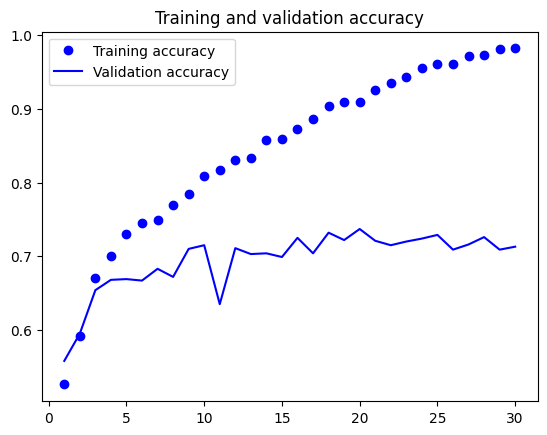

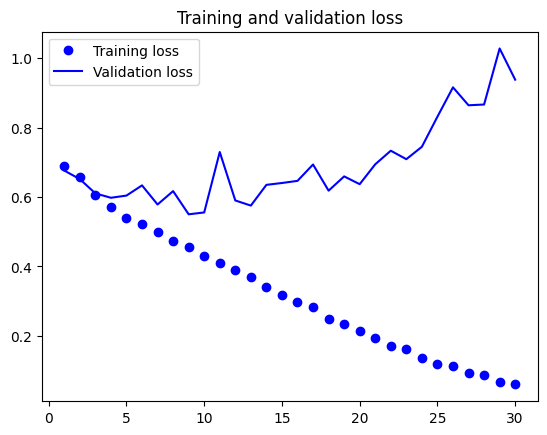

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

从上图可以看出，这是典型的过拟合。训练数据的正确率一直在上升，误差一直在下降，但是验证数据的正确率就只停在了 70% 左右，而误差也在上升。